In [1]:
import bagpy
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np
from tqdm import tqdm
import PIL.Image as Image 
import io
from matplotlib import pyplot as plt


In [2]:
from bagpy import bagreader

#b = bagreader(r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\2021-03-12_11-41-55_0\2021-03-12_11-41-55_0.bag')
#b = bagreader(r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\pedestrian_on_road\2021-03-12_11-29-58\2021-03-12_11-29-59_0.bag')
b = bagreader(r'D:\teja\scenario1\2021-06-10_08-54-06\2021-06-10_08-54-07_0.bag')
# D:\teja\scenario5\2021-06-10_14-37-57\2021-06-10_14-38-58_1.bag -5559 sequence index missing
# D:\teja\scenario5\2021-06-10_14-39-30\2021-06-10_14-40-31_1.bag - No messages
# D:\teja\scenario5\2021-06-10_14-47-20\2021-06-10_14-48-21_1.bag - 135 messages, 79502.0
# D:\teja\scenario6\2021-06-10_14-59-03\2021-06-10_15-00-04_1.bag, because of 36976.0 is not in list
# D:\teja\scenario6\2021-06-10_14-59-03\2021-06-10_15-01-04_2.bag, because of 38478.0
# D:\teja\scenario7\2021-06-10_15-14-27\2021-06-10_15-15-28_1.bag, because of 60153.0 is not in list
# ERROR- Error handling the file D:\teja\scenario7\2021-06-10_15-15-45\2021-06-10_15-16-46_1.bag, because of 62127.0 is not in list
# 
bag = b.reader

[INFO]  Data folder D:\teja\scenario1\2021-06-10_08-54-06\2021-06-10_08-54-07_0 already exists. Not creating.


In [3]:

topic_list = ['/em/fused_grid', '/sensorik/axis_front/image/compressed', '/vehicle/odometry', '/function/pathing_mlteleop']

pathing_msgs = []
grid_msgs = []
grid_seqs = []
odom_msgs = []
odom_seqs = []
image_msgs = []
image_seqs = []
count = 0
for topic, msg, t in bag.read_messages(topics=topic_list):
    if topic == "/function/pathing_mlteleop":
        pathing_msgs.append(msg)

    if topic == "/em/fused_grid":
        grid_msgs.append(msg)
        grid_seqs.append(msg.header.seq)
        
    if topic == "/vehicle/odometry":
        odom_msgs.append(msg)
        odom_seqs.append(msg.header.seq)
    if topic == "/sensorik/axis_front/image/compressed":
        image_msgs.append(msg)
        image_seqs.append(msg.header.seq)
    if count==10000:
        break
    else: count +=1
bag.close()

print('len')
print('pathing_msgs',len(pathing_msgs))
print('grid_msgs',len(grid_msgs))
print('odom_msgs',len(odom_msgs))
print('image_msgs',len(image_msgs))


len
pathing_msgs 95
grid_msgs 1476
odom_msgs 5947
image_msgs 1492


In [4]:
pathing_msgs[55].path_options[2].reference_path[0]

point: 
  s: 0.0
  x: -0.3525413776240343
  y: -21.55788935169154
  theta: 0.0
  kappa: 0.0
  kappa_prime: 0.0
left_boundaries: 
  lane: 2.333208220787419
  road: 0.9147296607587154
  obstacle: 0.0
right_boundaries: 
  lane: 22.247108122114724
  road: -21.11691312700143
  obstacle: 0.0

In [5]:
pathing_msgs[55].path_options[2].reference_path[0].left_boundaries

lane: 2.333208220787419
road: 0.9147296607587154
obstacle: 0.0

In [6]:
pathing_msgs[55].path_options[2].reference_path[0].right_boundaries

lane: 22.247108122114724
road: -21.11691312700143
obstacle: 0.0

In [7]:
def __construct_bound_widths(list_of_points):

    l_bnd_x,l_bnd_y,r_bnd_x,r_bnd_y = ([] for i in range(4))

    for path in list_of_points:
    
        l_bnd_x.append(path.left_boundaries.lane*-1)
        l_bnd_y.append(path.right_boundaries.lane*-1)
    
        r_bnd_x.append(path.left_boundaries.road)
        r_bnd_y.append(path.right_boundaries.road)
        #print(bnd_x,bnd_y)
    return l_bnd_x,l_bnd_y,r_bnd_x,r_bnd_y

In [8]:
l_bnd_x,l_bnd_y,r_bnd_x,r_bnd_y = __construct_bound_widths(pathing_msgs[55].path_options[2].reference_path)

In [9]:
len(r_bnd_y)

18

## For extracting boundaries

In [10]:
left_boundary_points = ((pathing_msgs[55].path_options[2].reference_path[0].left_boundaries.lane)*-1,(pathing_msgs[55].path_options[2].reference_path[0].right_boundaries.lane)*-1)
print(f"Left boundary point: {left_boundary_points}")

print(f"Car centre path point {(pathing_msgs[55].path_options[1].reference_path[0].point.x,pathing_msgs[55].path_options[1].reference_path[0].point.y)}")

right_boundary_points = ((pathing_msgs[55].path_options[2].reference_path[0].left_boundaries.road),(pathing_msgs[55].path_options[2].reference_path[0].right_boundaries.road))
print(f"Right boundary point: {right_boundary_points}")

Left boundary point: (-2.333208220787419, -22.247108122114724)
Car centre path point (-0.3525413776240343, -21.55788935169154)
Right boundary point: (0.9147296607587154, -21.11691312700143)


In [11]:
pathing_msgs[55].path_options[1].reference_path[0]

point: 
  s: 0.0
  x: -0.3525413776240343
  y: -21.55788935169154
  theta: 0.0
  kappa: 0.0
  kappa_prime: 0.0
left_boundaries: 
  lane: 33600.0
  road: 36772.0
  obstacle: 147246.0
right_boundaries: 
  lane: 1623308077.411396
  road: 1623308077.7191722
  obstacle: 1623308077.682623

## Extracting car orientation from odo data

In [12]:
list_odo_msgs = []
for i,examplary_pathing_msg in enumerate(tqdm(pathing_msgs)):
    odom_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.obstacle
    odom_idx = odom_seqs.index(odom_seq)
    odom_msg = odom_msgs[odom_idx]
    #list_odo_msgs.append(odom_msg)
    list_odo_msgs.append((odom_msg.pos_x,odom_msg.pos_y,odom_msg.heading))
    #print("\n",odom_msg.pos_x,odom_msg.pos_y)
np_odo_data = np.asarray(list_odo_msgs)

100%|██████████| 95/95 [00:00<00:00, 2065.21it/s]


In [13]:
np_odo_data[70]

array([  0.27200031, -26.35600281,   1.56158099])

## Grid extraction along with grid resolution and grid origin

In [14]:
list_all_grid_data=[]
list_origin_res = []

list_all = []

for i,examplary_pathing_msg in enumerate(tqdm(pathing_msgs)):

    #get sequences aligning with pathing messages
    grid_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.lane

    """
    grid is saved as vector in grid_msg.data
    grid_msg.info gives information about properties, i.e. width, height, resolution, position in odometry frame
    """
    grid_idx = grid_seqs.index(grid_seq)
    grid_msg = grid_msgs[grid_idx]

    grid_data = np.asarray(grid_msg.data)
    grid_data = grid_data.reshape(grid_msg.info.width, grid_msg.info.height)
    
    # New inputs
    grid_origin_x = grid_msg.info.origin.position.x
    grid_origin_y = grid_msg.info.origin.position.y
    grid_resolution = grid_msg.info.resolution
   
    # append grid data
    list_all_grid_data.append(grid_msg) 
    list_origin_res.append((grid_origin_x,grid_origin_y,grid_resolution))
    
#converted appended grids to np array
np_all_grid_data = np.asarray(list_all_grid_data)
np_all_grid_orig_res = np.asarray(list_origin_res)

100%|██████████| 95/95 [00:16<00:00,  5.62it/s]


In [15]:
np_all_grid_orig_res[10]

array([-114.60000456, -111.15000337,    0.15000001])

In [21]:
_READ_ROSBAG =1
_MAX_LENGTH = 25
_ZERO_PADDING = 0

class np_maker():

    def __init__(self,pathing_msgs,max_length):
        self.pathing_msgs = pathing_msgs
        self.max_length = max_length
        self.extract_msg_cnt = 220

    @staticmethod
    def __np_reshape_frm_list(list_path,new_shape):
        return np.reshape((np.asarray(list_path)),new_shape)
    
    @staticmethod
    def __np_hstack_list(self,list1,list2,new_shape):
        assert len(list1)==len(list2)
        np_list1 = self.__np_reshape_frm_list(list1,new_shape)
        np_list2 = self.__np_reshape_frm_list(list2,new_shape)
        return np.hstack((np_list1,np_list2))
    
    @staticmethod
    def __padd_values(n,val):
        listofzeros = [val] * n
        return listofzeros

    from typing import List
    def __padded_path(self,unpadded_path:List,value:float)->List:
        padded_path = unpadded_path.extend(self.__padd_values((self.max_length-len(unpadded_path)),value))
        return padded_path

    @staticmethod
    def __construct_path(list_of_points):
        path_x = [] 
        path_y = []
        for path in list_of_points:
            path_x.append(path.point.x)
            path_y.append(path.point.y)

        return path_x,path_y

    @staticmethod
    def __construct_bnd_lane(list_of_points):

        l_bnd_x,l_bnd_y,r_bnd_x,r_bnd_y = ([] for i in range(4))

        for path in list_of_points:
        
            l_bnd_x.append(path.left_boundaries.lane*-1)
            l_bnd_y.append(path.right_boundaries.lane*-1)
        
            r_bnd_x.append(path.left_boundaries.road)
            r_bnd_y.append(path.right_boundaries.road)
            #print(bnd_x,bnd_y)
        return l_bnd_x,l_bnd_y,r_bnd_x,r_bnd_y       

    def __padd_bnd_lanes(self,left_bnd_x,left_bnd_y,right_bnd_x,right_bnd_y):
        if (len(left_bnd_x)<self.max_length) & (len(left_bnd_y)<self.max_length) & (len(right_bnd_x)<self.max_length) & (len(right_bnd_y)<self.max_length):
            left_bnd_x.extend(self.__padd_values(self.max_length-len(left_bnd_x),left_bnd_x[-1]))
            left_bnd_y.extend(self.__padd_values(self.max_length-len(left_bnd_y),left_bnd_y[-1]))
            right_bnd_x.extend(self.__padd_values(self.max_length-len(right_bnd_x),right_bnd_x[-1]))
            right_bnd_y.extend(self.__padd_values(self.max_length-len(right_bnd_y),right_bnd_y[-1]))
        return left_bnd_x,left_bnd_y,right_bnd_x,right_bnd_y

    @staticmethod
    def __assert_all_lengths(self,path1_x,path1_y,path2_x,path2_y):
        # check if every path is as long as the maximum length
        assert len(path1_x)==self.max_length 
        assert len(path1_y)==self.max_length 
        assert len(path2_x)==self.max_length 
        assert len(path2_y)==self.max_length

    def create_np_path(self):

        list_all_init_path = []
        list_all_opt_path = []
        list_all_bnd = []
        print("Converting path data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            init_path_x,init_path_y = self.__construct_path(examplary_pathing_msg.path_options[0].reference_path)

            opt_path_x,opt_path_y = self.__construct_path(examplary_pathing_msg.path_options[2].reference_path)

            left_bnd_x,left_bnd_y,right_bnd_x,right_bnd_y = self.__construct_bnd_lane(examplary_pathing_msg.path_options[2].reference_path)

            # pad tyo a fixed length
            if _ZERO_PADDING:
                if len(init_path_x)<self.max_length:
                    init_path_x.extend(self.__padd_values(self.max_length-len(init_path_x),0))
                    #init_path_x = self.__padded_path(self,init_path_x)
                    init_path_y.extend(self.__padd_values(self.max_length-len(init_path_y),0))
            
                if len(opt_path_x)<self.max_length:
                    opt_path_x.extend(self.__padd_values(self.max_length-len(opt_path_x),0))
                    opt_path_y.extend(self.__padd_values(self.max_length-len(opt_path_y),0))
            else:

                if len(init_path_x)<self.max_length:
                    init_path_x.extend(self.__padd_values(self.max_length-len(init_path_x),init_path_x[-1]))
                    #init_path_x = self.__padded_path(self,init_path_x)
                    init_path_y.extend(self.__padd_values(self.max_length-len(init_path_y),init_path_y[-1]))
            
                if len(opt_path_x)<self.max_length:
                    opt_path_x.extend(self.__padd_values(self.max_length-len(opt_path_x),opt_path_x[-1]))
                    opt_path_y.extend(self.__padd_values(self.max_length-len(opt_path_y),opt_path_y[-1]))
            """
            if (len(left_bnd_x)<self.max_length) & (len(left_bnd_y)<self.max_length) & (len(right_bnd_x)<self.max_length) & (len(right_bnd_y)<self.max_length):
                left_bnd_x.extend(self.__padd_values(self.max_length-len(left_bnd_x),left_bnd_x[-1]))
                left_bnd_y.extend(self.__padd_values(self.max_length-len(left_bnd_y),left_bnd_y[-1]))
                right_bnd_x.extend(self.__padd_values(self.max_length-len(right_bnd_x),right_bnd_x[-1]))
                right_bnd_y.extend(self.__padd_values(self.max_length-len(right_bnd_y),right_bnd_y[-1]))
            """
            left_bnd_x,left_bnd_y,right_bnd_x,right_bnd_y=self.__padd_bnd_lanes(left_bnd_x,left_bnd_y,right_bnd_x,right_bnd_y)
         
            #check for length
            self.__assert_all_lengths(self,init_path_x,init_path_y,opt_path_x,opt_path_y)

            #pair x and y and 
            np_init_path = self.__np_hstack_list(self,init_path_x,init_path_y,new_shape=(self.max_length,1))
            np_opt_path = self.__np_hstack_list(self,opt_path_x,opt_path_y,new_shape=(self.max_length,1))
            np_left_bnd = self.__np_hstack_list(self,left_bnd_x,left_bnd_y,new_shape=(self.max_length,1))
            np_right_bnd = self.__np_hstack_list(self,right_bnd_x,right_bnd_y,new_shape=(self.max_length,1))

            # append paths from all pathing messages
            list_all_init_path.append(np_init_path)
            list_all_opt_path.append(np_opt_path)
            #list_all_bnd.append((np.asarray(np_left_bnd),np.asarray(np_right_bnd)))
            list_all_bnd.append((np_left_bnd,np_right_bnd))

        # Convert the all paths appended list to numpy array
        np_all_initp = np.asarray(list_all_init_path)
        np_all_optp = np.asarray(list_all_opt_path)  

        np_all_bndp = np.asarray(list_all_bnd)      

        return np_all_initp, np_all_optp, np_all_bndp

    def create_np_grid(self):

        list_all_grid_data =[]
        list_origin_res = []
        print("Converting grid data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            #get sequences aligning with pathing messages
            grid_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.lane

            """
            grid is saved as vector in grid_msg.data
            grid_msg.info gives information about properties, i.e. width, height, resolution, position in odometry frame
            """
            grid_idx = grid_seqs.index(grid_seq)
            grid_msg = grid_msgs[grid_idx]

            grid_data = np.asarray(grid_msg.data)
            grid_data = grid_data.reshape(grid_msg.info.width, grid_msg.info.height)

            # New inputs
            grid_origin_x = grid_msg.info.origin.position.x
            grid_origin_y = grid_msg.info.origin.position.y
            grid_resolution = grid_msg.info.resolution

            # append grid data
            list_all_grid_data.append(grid_data) 
            list_origin_res.append((grid_origin_x,grid_origin_y,grid_resolution))
        
        #converted appended grids to np array
        np_all_grid_orig_res = np.asarray(list_origin_res)

        np_all_grid_data = np.asarray(list_all_grid_data)

        return np_all_grid_data,np_all_grid_orig_res

    def create_np_img(self):
        list_all_img_data =[]
        print("Converting grid data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            image_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.road
            image_idx = image_seqs.index(image_seq)
            image_msg = image_msgs[image_idx]

            # Convert compressed image(byte string) to RAW using
            img = Image.open(io.BytesIO(image_msg.data))
            #convert PIL image object to numpy array
            np_img = np.asarray(img)
            list_all_img_data.append(np_img)

        np_all_img_data = np.asarray(list_all_img_data)

        return np_all_img_data
        
    def create_np_odo(self):
        list_all_odo_data = []
        print("Converting Odometer data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            odom_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.obstacle
            odom_idx = odom_seqs.index(odom_seq)
            odom_msg = odom_msgs[odom_idx]

            #adding only position (x,y, heading), check odo_msg for other data(heading, angle and others) thats available
            list_all_odo_data.append((odom_msg.pos_x,odom_msg.pos_y,odom_msg.heading))
        
        np_all_odo_data = np.asfarray(list_all_odo_data)

        return np_all_odo_data


In [27]:
convert_2_np = np_maker(pathing_msgs,25)
np_init_path,np_opt_path,np_bnd_path = convert_2_np.create_np_path()
import time
time.sleep(1)
np_grid_data,np_grid_org_res = convert_2_np.create_np_grid()
#np_img_data = convert_2_np.create_np_img()
np_odo_data = convert_2_np.create_np_odo()


100%|██████████| 95/95 [00:00<00:00, 6806.61it/s]Converting path data to numpy........ 

100%|██████████| 95/95 [00:00<00:00, 8636.43it/s]Converting Odometer data to numpy........ 



In [35]:
#grid origin x,grid origin y , grid resolution (samples,3)
print("OGM origin and resolution data shape",np.shape(np_grid_org_res))
#grid data(OGM-samples,1536,1536)
print("OGM data shape",np.shape(np_grid_data))

# LEft and right boundaries of the path shape:(samples,2, 25,2) index[1]=2 implies two boundaries left and the right
print("Left and right boundaries together shape",np.shape(np_bnd_path))

#car centre-x,y,heading
print(np.shape(np_odo_data))

print(np.shape(np_bnd_path[:,0,:,:]))
print(np.shape(np_bnd_path[:,1,:,:]))

OGM origin and resolution data shape (95, 3)
OGM data shape (95, 1536, 1536)
Left and right boundaries together shape (95, 2, 25, 2)
(95, 3)
(95, 25, 2)
(95, 25, 2)


In [ ]:

#print((np_bnd_path[0,0,:,:]))
#print((np_bnd_path[0,1,:,:]))
#print(np.shape(np_img_data))
#0.1500000
test_idx=50
plt.figure(figsize=(7,7))
plt.plot(np_bnd_path[test_idx,0,:,0],np_bnd_path[test_idx,0,:,1],'o-', color='red')

plt.plot(np_init_path[test_idx,:,0],np_init_path[test_idx,:,1],'o-', color='green')
plt.plot(np_opt_path[test_idx,:,0],np_opt_path[test_idx,:,1],'o-', color='black')

plt.plot(np_bnd_path[test_idx,1,:,0],np_bnd_path[test_idx,1,:,1],'o-', color='blue')

plt.plot(np_odo_data[test_idx,0],np_odo_data[test_idx,1],'r*', color = 'brown',markersize=18)

plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','right bound', 'car_centre'], loc='lower left')
print(np.shape(np_bnd_path[:,0,:,:]))


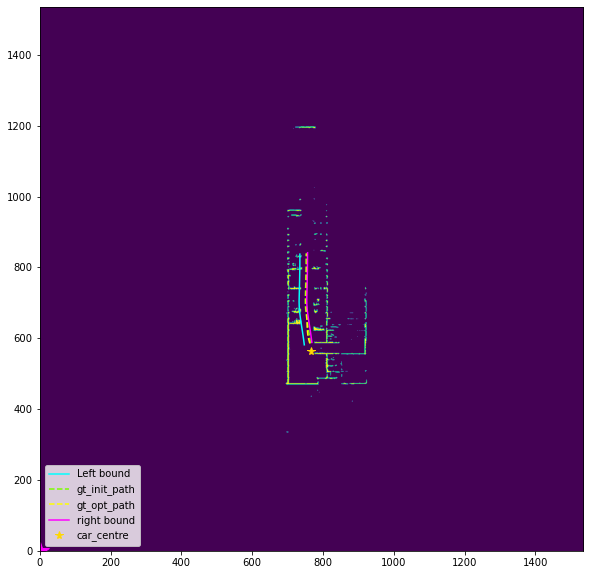

In [32]:
test_idx=77

plt.figure(figsize=(10,10))
#plt.subplot(1,2,1)

grid_org_x = np_grid_org_res[test_idx,0]#-114.60000456
grid_org_y = np_grid_org_res[test_idx,1]#-111.15000337 
res =   np_grid_org_res[test_idx,2]#0.15000001

plt.plot((np_bnd_path[test_idx,0,:,0]-grid_org_x)/res,(np_bnd_path[test_idx,0,:,1]-grid_org_y)/res, color='cyan',markersize=2)

plt.plot((np_init_path[test_idx,:,0]-grid_org_x)/res,(np_init_path[test_idx,:,1]-grid_org_y)/res,'--', color='lawngreen',markersize=1)
plt.plot((np_opt_path[test_idx,:,0]-grid_org_x)/res,(np_opt_path[test_idx,:,1]-grid_org_y)/res,'--', color='yellow',markersize=1)

plt.plot((np_bnd_path[test_idx,1,:,0]-grid_org_x)/res,(np_bnd_path[test_idx,1,:,1]-grid_org_y)/res, color='magenta',markersize=2)


plt.plot((np_odo_data[test_idx,0]-grid_org_x)/res,(np_odo_data[test_idx,1]-grid_org_y)/res,'r*', color = 'gold',markersize=8)


plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','right bound', 'car_centre'], loc='lower left')
#plt.subplot(1,2,2)
#plt.imshow(np_img_data[test_idx],origin = 'upper')

#plt.plot(np_odo_data[test_idx,0]*500,np_odo_data[test_idx,1]*500,'r*', color = 'yellow', markersize=18)

plt.imshow(np_grid_data[test_idx],origin='lower')
plt.plot(0,0,'r*', color = 'magenta',markersize=18)



In [51]:
# Check Data Balance
count=0
list_diff=[]
for i in range(len(np_opt_path)):24
    if np.array_equiv(np_opt_path[i],np_init_path[i]):
        count +=1
    else:
        list_diff.append(i)

print("Paths that are similar: {}, which is {} of total data".format(count,(count/len(np_init_path))))
print("Paths that are dissimalar: {},which is {} of total data".format((len(np_init_path)-count),((len(np_init_path)-count)/len(np_init_path))))

print(list_diff)

Paths that are similar: 72, which is 0.7578947368421053 of total data
Paths that are dissimalar: 23,which is 0.24210526315789474 of total data
[0, 1, 2, 3, 20, 21, 24, 28, 29, 30, 35, 37, 38, 39, 40, 41, 42, 43, 49, 50, 57, 77, 79]


In [61]:
#save non zero padding (padding with last value) with _nzp extention in file name

#np.save('_np_imgdata',np_img_data)
#np.save('_np_initpath_nzp',np_init_path)
#np.save('_np_optpath_nzp',np_opt_path)
#np.save('_np_griddata',np_grid_data)

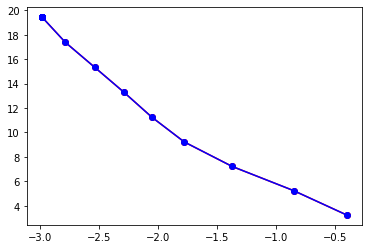

In [36]:
test_idx=55
plt.plot(np_init_path[test_idx,:,0],np_init_path[test_idx,:,1],'o-', color='red')
plt.plot(np_opt_path[test_idx,:,0],np_opt_path[test_idx,:,1],'o-', color='blue')

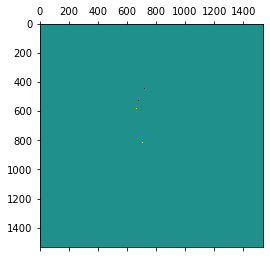

In [37]:
from matplotlib import pyplot as plt 
plt.matshow(np_grid_data[0]-np_grid_data[56])

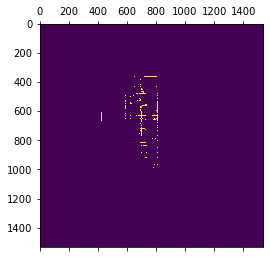

In [38]:
plt.matshow(np_grid_data[80])

In [18]:
# Example for a single pathing_msg:
init_path_x = []
init_path_y = []
opt_path_x = []
opt_path_y = []

grid_msg = None
image_msg = None
odom_msg = None

max_length = 25
np_init_paths = np.empty((1,max_length,2))

for examplary_pathing_msg in pathing_msgs[0:1]:
    #examplary_pathing_msg = pathing_msgs[0]
    
    print("examplary_pathing_msg")
    #print(examplary_pathing_msg)

    '''
    for init_path in examplary_pathing_msg.path_options[0].reference_path:
        init_path_x.append(init_path.point.x)
        init_path_y.append(init_path.point.y)
    '''
    init_path_x, init_path_y = construct_path(examplary_pathing_msg.path_options[0].reference_path)
    init_path_x = padd_w_value(init_path_x,0,25)
    opt_path_x, opt_path_y = construct_path(examplary_pathing_msg.path_options[2].reference_path)

    '''
    for opt_path in examplary_pathing_msg.path_options[2].reference_path:
        opt_path_x.append(opt_path.point.x)
        opt_path_y.append(opt_path.point.y)
    '''
    # corresponding occupancy grid, camera and odometry sequences (ID's):
    # this saving method is a workaround for the corresponding ID's
    grid_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.lane
    image_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.road
    odom_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.obstacle

    # corresponding occupancy grid, camera and odometry messages:
    """
    grid is saved as vector in grid_msg.data
    grid_msg.info gives information about properties, i.e. width, height, resolution, position in odometry frame
    """
    grid_idx = grid_seqs.index(grid_seq)
    grid_msg = grid_msgs[grid_idx]
    # print('grid_msg.info')
    # print(grid_msg.info)

    """
    1280x720, RGB Image
    """
    image_idx = image_seqs.index(image_seq)
    image_msg = image_msgs[image_idx]
    # Convert compressed image to RAW
    #bridge = CvBridge()
    #img = bridge.compressed_imgmsg_to_cv2(image_msg)
    # print(img.shape)

    """
    odom_msg provides information about the current position in the odometry frame (pos_x, pos_y, heading)
    the idea is to provide the NN information for the correlation between camera image, the corresponding car position and the path to be optimized/predicted
    """
    odom_idx = odom_seqs.index(odom_seq)
    odom_msg = odom_msgs[odom_idx]

examplary_pathing_msg


NameError: name 'construct_path' is not defined

100%|██████████| 2/2 [00:00<00:00, 55.51it/s]


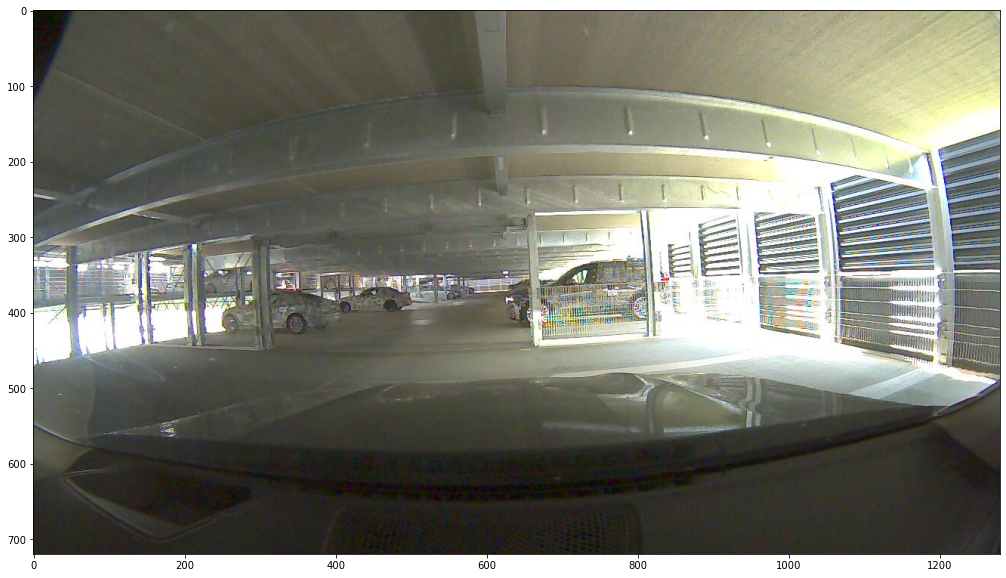

In [55]:
list_all_img_data=[]
for i,examplary_pathing_msg in enumerate(tqdm(pathing_msgs[0:2])):

    image_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.road
    image_idx = image_seqs.index(image_seq)
    image_msg = image_msgs[image_idx]

    # Convert compressed image(byte string) to RAW using
    img = Image.open(io.BytesIO(image_msg.data))
    #convert PIL image object to numpy array
    np_img = np.asarray(img)
    list_all_img_data.append(np_img)

np_all_img_data = np.asarray(list_all_img_data)

plt.figure(figsize=(20,10))
plt.imshow(np_all_img_data[0])